# Figure 5: NetMHC class II prediction overview 

In [1]:
# imported packages
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as plticker
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.patches import Polygon
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import cm
import scipy.special
import scipy.integrate as it
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.stats import kde
import copy
import glob, os
import re
# from sklearn import datasets, linear_model
import pandas as pd
from decimal import *
from operator import itemgetter    
from collections import OrderedDict
import timeit
import time 
import csv
import seaborn as sns 
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import LogLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:

timestr = time.strftime("%Y%m%d") # get current date 
plt.rcParams.update({'font.sans-serif':'Arial'})

# Load NetMHC class II scores 

In [3]:
# load scores from NetMHC II 

# parameters
param = '%Rank_EL' # let's do it on EL ranks first 

# NOTE: In the original file (sub), I was missing a score for DNMT3A_R736C_ch so I generated it separately with the same code and will concatenate the files here 
# load the file with binding predictions across variants
pred_file_dpq_sub = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240211_NetMHC_HLA_UKBB_with_affinities_DP_DQ_bestscores.csv"
pred_file_dpq_r736c = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240215_NetMHC_HLA_UKBB_with_affinities_DP_DQ_R736C_bestscores.csv"
pred_file_dpq_stop = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240214_NetMHC_HLA_UKBB_with_affinities_DP_DQ_stopcodons_bestscores.csv"
pred_method = pred_file_dpq_sub.split('_out')[0] # all are with the same method so does not matter which file you end up using 
 
# organize file with prediction scores for DP and DQ alleles 
pred_filename_dpq_sub = pred_file_dpq_sub.split('/')[2].split('.')[0]
pred_filename_dpq_stop = pred_file_dpq_stop.split('/')[2].split('.')[0]
pred_df_dpq_sub = pd.read_csv(pred_file_dpq_sub)
pred_df_dpq_r736c = pd.read_csv(pred_file_dpq_r736c)
pred_df_dpq_stop = pd.read_csv(pred_file_dpq_stop)

# In the sub file, I had some predictions for STOP-codon-containing variants, I don't want these so remove them
pred_df_dpq_sub = pred_df_dpq_sub[~pred_df_dpq_sub['gene_var'].str.contains('\*')]

# concat the files 
pred_df_dpq = pd.concat([pred_df_dpq_sub, pred_df_dpq_stop, pred_df_dpq_r736c], ignore_index = True)
pred_df_dpq['gene_var_gt'] = pred_df_dpq['gene'] + '_' + pred_df_dpq['variant'] + '_' + pred_df_dpq['genotype'] # create a column that includes all genotype data

# organize file with prediction scores for DR alleles 
pred_file_dr_sub = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240214_NetMHC_HLA_UKBB_with_affinities_DR_bestscores.csv"
pred_file_dr_r736c = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240215_NetMHC_HLA_UKBB_with_affinities_DR_R736C_bestscores.csv"
pred_file_dr_stop = "/Users/barbarawalkowiak/Desktop/msc_thesis/task1_predict_binding_to_HLA/NetMHCII_out/scores/20240214_NetMHC_HLA_UKBB_with_affinities_DR_stopcodons_bestscores.csv"

# organize file with prediction scores for DP and DQ alleles 
pred_filename_dr_sub = pred_file_dr_sub.split('/')[2].split('.')[0]
pred_filename_dr_stop = pred_file_dr_stop.split('/')[2].split('.')[0]
pred_df_dr_sub = pd.read_csv(pred_file_dr_sub)
pred_df_dr_r736c = pd.read_csv(pred_file_dr_r736c)
pred_df_dr_stop = pd.read_csv(pred_file_dr_stop)

# In the sub file, I had some predictions for STOP-codon-containing variants, I don't want these so remove them
pred_df_dr_sub = pred_df_dr_sub[~pred_df_dr_sub['gene_var'].str.contains('\*')]

# concat the files 
pred_df_dr = pd.concat([pred_df_dr_sub, pred_df_dr_stop, pred_df_dr_r736c], ignore_index = True)
pred_df_dr['gene_var_gt'] = pred_df_dr['gene'] + '_' + pred_df_dr['variant'] + '_' + pred_df_dr['genotype'] # create a column that includes all genotype data
pred_df_dr.head(n = 5)


Unnamed: 0  Pos        HLA          Peptide  Of       Core  Core_Rel  \
0       81173    1  DRB1_0101  IRHLFALLKEYFACV   4  FALLKEYFA      0.99   
1       81178    1  DRB1_0102  SVPVIRHLFALLKEY   4  IRHLFALLK      0.96   
2       81191    1  DRB1_0103  IRHLFALLKEYFACV   4  FALLKEYFA      0.99   
3       81196    1  DRB1_0301  SVPVIRHLFALLKEY   4  IRHLFALLK      0.92   
4       81206    1  DRB1_0302  VPVIRHLFALLKEYF   3  IRHLFALLK      0.89   

   Inverted Identity  Score_EL  ...  BindLevel    gene variant genotype  \
0         0    seq_9  0.035335  ...        NaN  DNMT3A   P904L       ch   
1         0    seq_5  0.075223  ...        NaN  DNMT3A   P904L       ch   
2         0    seq_9  0.015829  ...        NaN  DNMT3A   P904L       ch   
3         0    seq_5  0.003383  ...        NaN  DNMT3A   P904L       ch   
4         0    seq_6  0.003467  ...        NaN  DNMT3A   P904L       ch   

       gene_var Score_BA %Rank_BA  Affinity (nM)  Affinity(nM)  \
0  DNMT3A_P904L      NaN      NaN            NaN           NaN   
1  DNMT3A_P904L      NaN      NaN            NaN           NaN   
2  DNMT3A_P904L      NaN      NaN            NaN           NaN   
3  DNMT3A_P904L      NaN      NaN            NaN           NaN   
4  DNMT3A_P904L      NaN      NaN            NaN           NaN   

       gene_var_gt  
0  DNMT3A_P904L_ch  
1  DNMT3A_P904L_ch  
2  DNMT3A_P904L_ch  
3  DNMT3A_P904L_ch  
4  DNMT3A_P904L_ch  

[5 rows x 22 columns]

In [4]:

# we need to move the format of the DP/DQ predictions to something that matches our UKBB genotyping and everything else 
def transform_format_DPQ(input_string):
    # Define a regular expression pattern to match the input format
    pattern = re.compile(r'HLA-(\w{3})(\d{1})(\d{4})-(\w{3})(\d{1})(\d{4})') # okay so this is the pattern we are trying to match

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1) # we are not including HLA annotations, this is the name of the first allele   
        group2 = int(match.group(2)) # there will be no zeroes, leave as it is 
        group3 = int(match.group(3)) # remove zeros at the start 
        group4 = match.group(4) # name of the second allele in the combination
        group5 = int(match.group(5)) # there will be no zeroes, leave as it is 
        group6 = int(match.group(6)) # remove zeros at the start 

        # Format the output string
        output_string = f'{group1}{group2}_{group3}-{group4}{group5}_{group6}' # stitch back 

        return output_string # return transformed string 

    # if no much, return original string 
    return 0

def transform_format_DR(input_string):
    # Define a regular expression pattern to match the input format
    pattern = re.compile(r'(\w{3})(\d{1})_(\d+)') # okay so this is the pattern we are trying to match

    # check if there is a match
    match = pattern.match(input_string)

    # if match, apply transformation
    if match:
        group1 = match.group(1) # we are not including HLA annotations, this is the name of the first allele   
        group2 = int(match.group(2)) # there will be no zeroes, leave as it is 
        group3 = int(match.group(3)) # remove zeros at the start 

        # Format the output string
        output_string = f'{group1}{group2}_{group3}' # stitch back 

        return output_string # return transformed string 

    # if no match, return original string 
    return 0


In [5]:

pred_df_dpq['HLA_formatted'] = pred_df_dpq['HLA'].map(transform_format_DPQ)
pred_df_dr['HLA_formatted'] = pred_df_dr['HLA'].map(transform_format_DR)

In [6]:

# add -log10(%Rank_EL)
pred_df_dpq['%Rank_EL_log'] = -1 * np.log10(pred_df_dpq['%Rank_EL'])
pred_df_dr['%Rank_EL_log'] = -1 * np.log10(pred_df_dr['%Rank_EL'])


In [7]:
# combine all dataframes

pred_df_all = pd.concat([pred_df_dpq, pred_df_dr], axis = 0)
pred_df_all['Allele_class'] = pred_df_all['HLA_formatted'].str[0:2]

# Plots 

In [8]:

# Distribution of scores for each variant 

def plot_distribution_of_scores(data, x, y, ylabel, color, plt_type, name, hue = None):

    plt.figure(figsize = (12, 4))

    # specify ordering 
    data['median'] = data.groupby(x)[y].transform('median')
    data_sort = data.sort_values(by = 'median', ascending = False)
    order = data_sort[x].unique()

    if plt_type == 'jitter':
        p1 = sns.stripplot(x = x, y = y, hue = hue, data = data, palette = color, order = order, size = 2.5, jitter = True, dodge = True) # jitter
        
        plt.title(f'Distribution of NetMHCIIpan scores of CH variants', fontsize = 14)
        plt.xlabel('Variant', fontsize = 12)
        p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right")
        plt.ylabel(ylabel, fontsize = 12)

        plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure5/{timestr}/{timestr}_score_distirbution_netmhcIIpan_{y}_{name}_stripp.pdf', bbox_inches='tight')

    if plt_type == 'box':
        p1 = sns.boxplot(x = x, y = y,  hue = hue, data = data, palette = color, order = order, showfliers = False,
            boxprops=dict(edgecolor='black'), medianprops=dict(color='black'), whiskerprops=dict(color='black')) # boxplot
        plt.title(f'Distribution of NetMHCIIpan scores of CH variants', fontsize = 14)
        plt.xlabel('Variant', fontsize = 12)
        p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right")
        plt.ylabel(ylabel, fontsize = 12)

        plt.savefig(f'/Users/barbarawalkowiak/Desktop/msc_thesis/project_report/figures/figure5/{timestr}/{timestr}_score_distirbution_netmhcIIpan_{y}_{name}_box.pdf', bbox_inches='tight')

/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_55538/238997853.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right")
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_55538/238997853.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right")
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_55538/238997853.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right")
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_55538/238997853.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right")
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_55538/238997853.py:17: UserWarning: Fixed

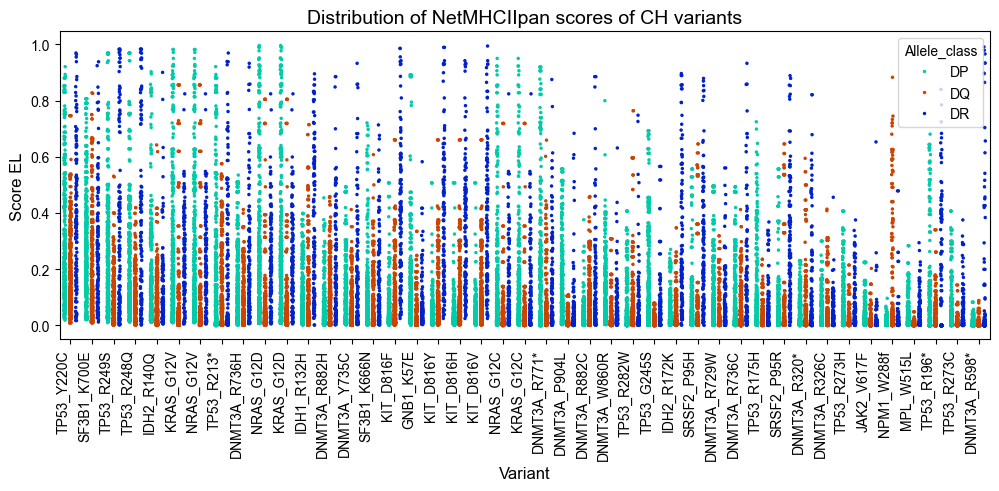

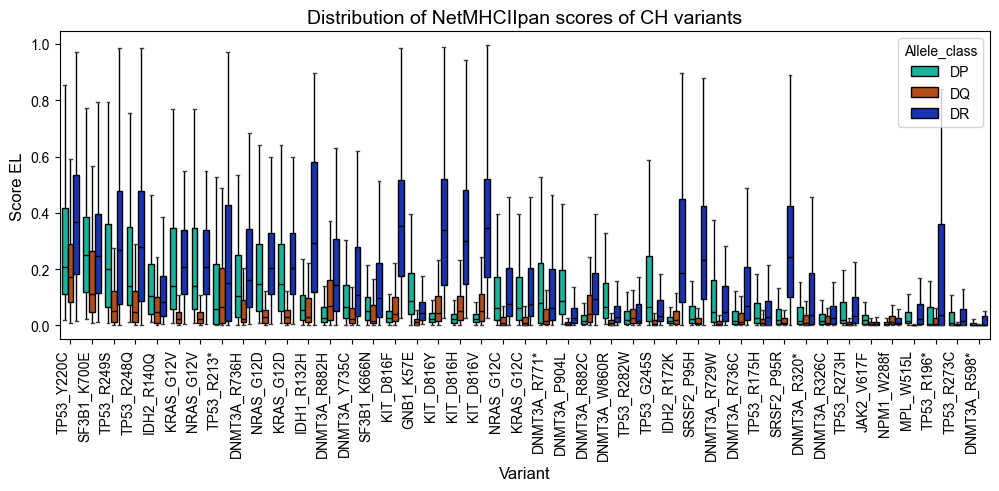

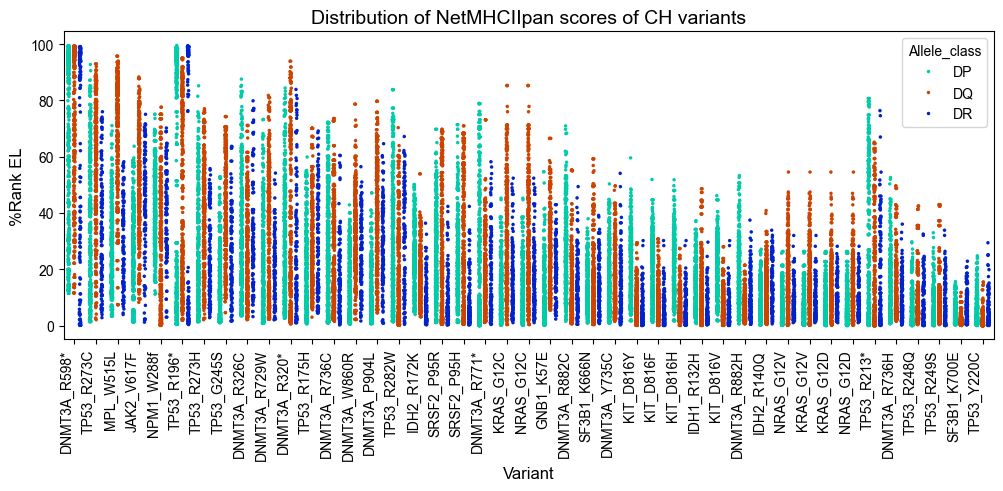

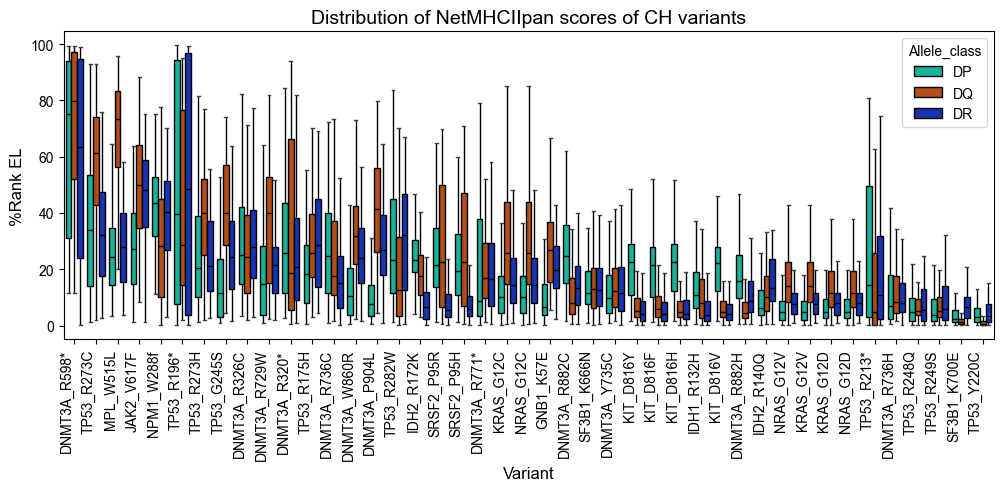

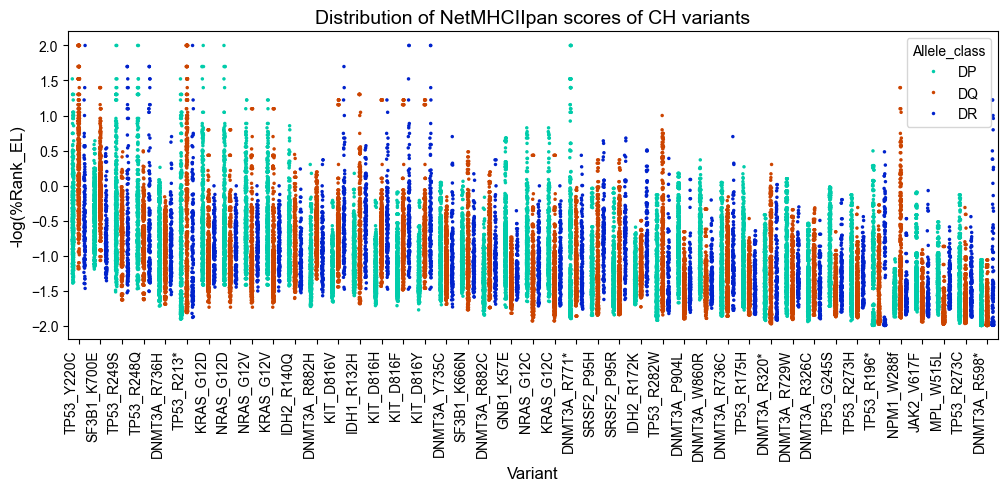

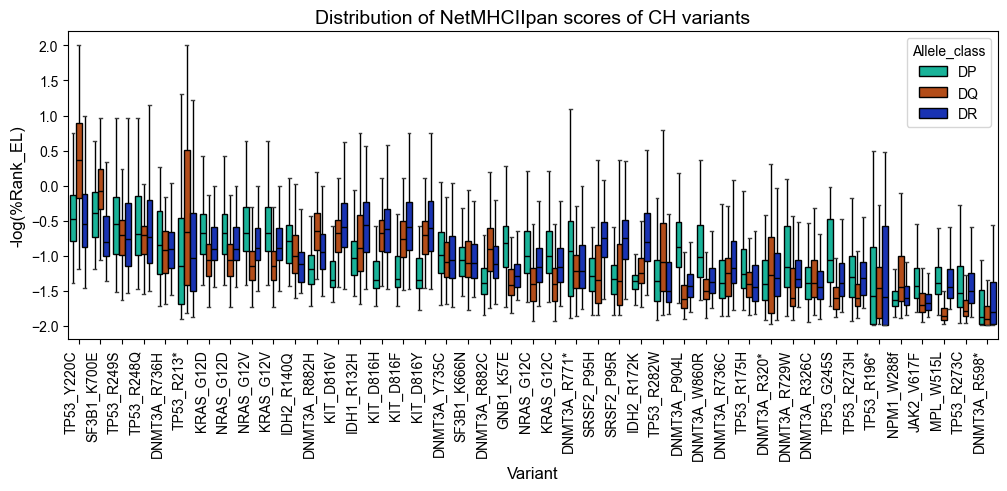

In [9]:

colors = ['#00ccaa', '#cc4400', '#0022cc']
plot_distribution_of_scores(pred_df_all, 'gene_var', 'Score_EL', 'Score EL', colors, 'jitter', 'split_by_hla', 'Allele_class')
plot_distribution_of_scores(pred_df_all, 'gene_var', 'Score_EL', 'Score EL', colors, 'box','split_by_hla', 'Allele_class')
plot_distribution_of_scores(pred_df_all, 'gene_var', '%Rank_EL', '%Rank EL', colors, 'jitter','split_by_hla', 'Allele_class')
plot_distribution_of_scores(pred_df_all, 'gene_var', '%Rank_EL', '%Rank EL', colors, 'box','split_by_hla', 'Allele_class')
plot_distribution_of_scores(pred_df_all, 'gene_var', '%Rank_EL_log', '-log(%Rank_EL)', colors, 'jitter','split_by_hla', 'Allele_class')
plot_distribution_of_scores(pred_df_all, 'gene_var', '%Rank_EL_log', '-log(%Rank_EL)', colors, 'box','split_by_hla', 'Allele_class')

/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_55538/238997853.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p1 = sns.stripplot(x = x, y = y, hue = hue, data = data, palette = color, order = order, size = 2.5, jitter = True, dodge = True) # jitter
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_55538/238997853.py:13: UserWarning: 
The palette list has fewer values (1) than needed (43) and will cycle, which may produce an uninterpretable plot.
  p1 = sns.stripplot(x = x, y = y, hue = hue, data = data, palette = color, order = order, size = 2.5, jitter = True, dodge = True) # jitter
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_55538/238997853.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  p1.set_xticklabels(p1.get_xticklabels(), rotation=90, ha="right")
/var/folders/pm/9p

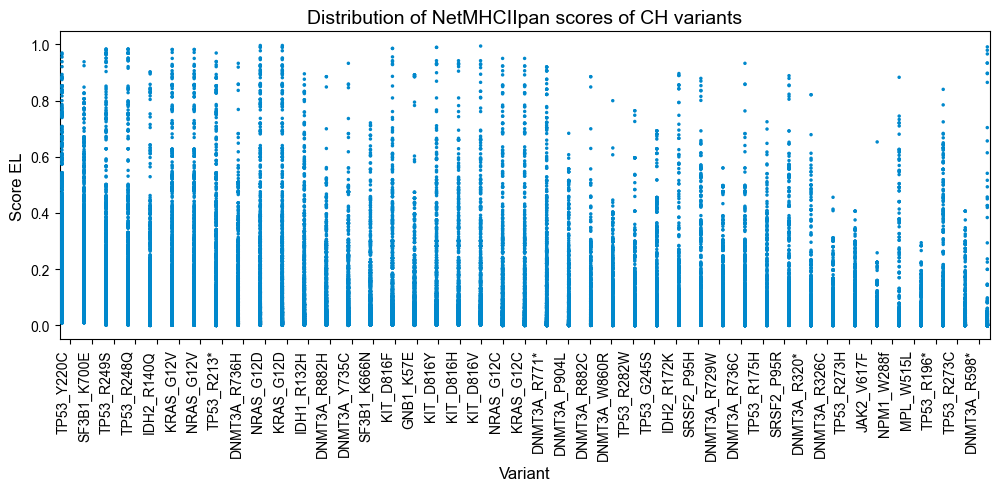

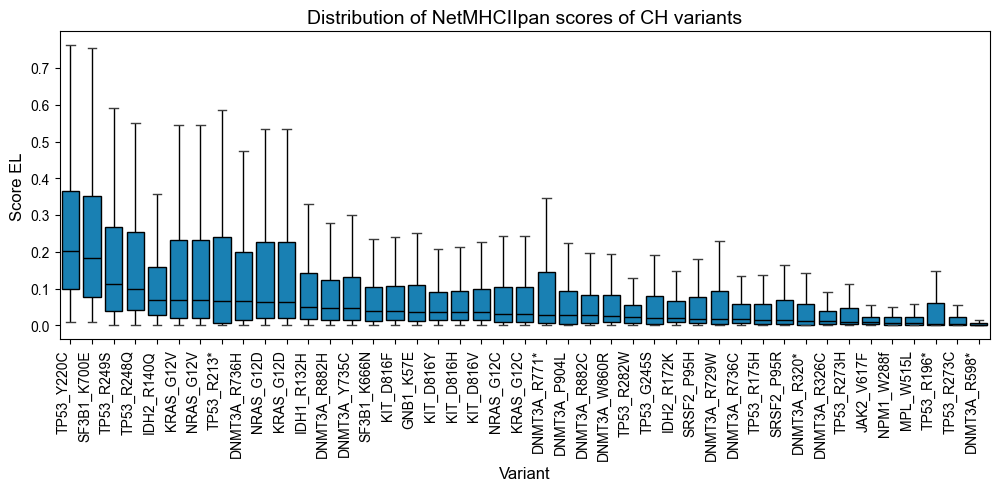

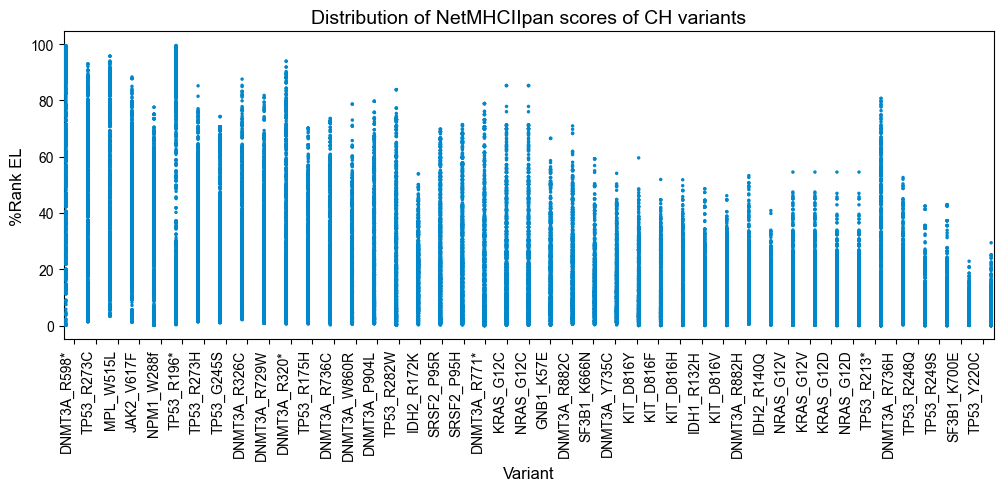

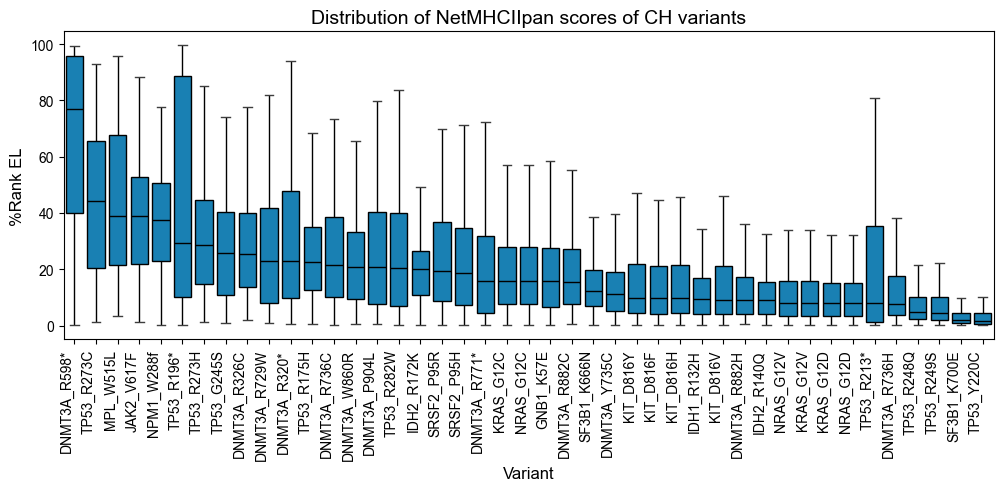

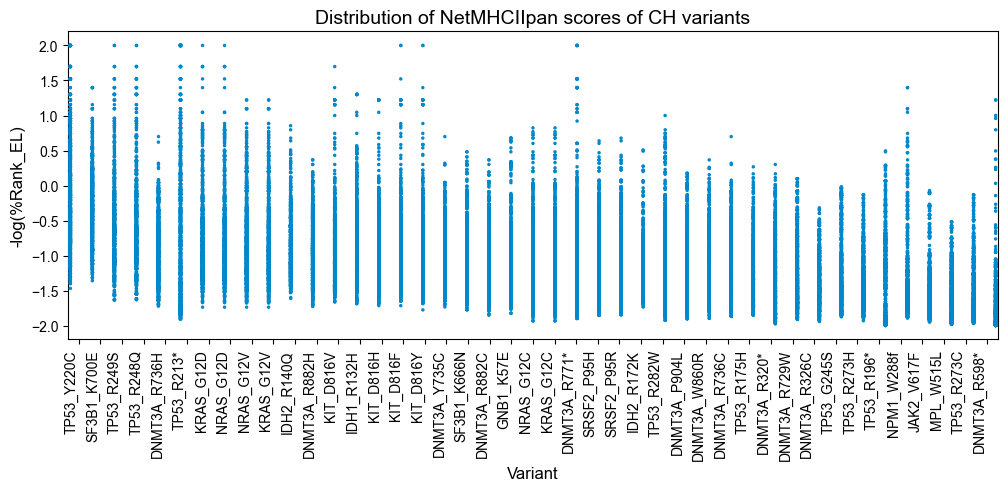

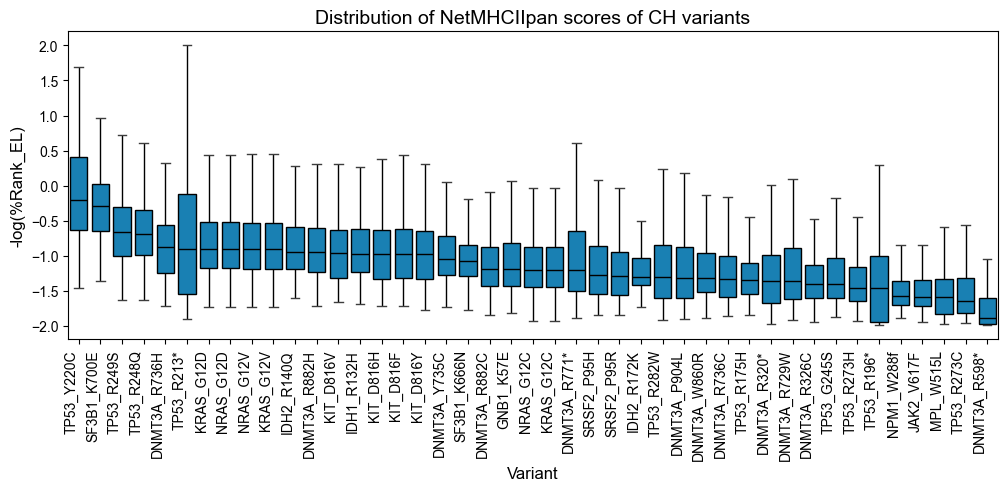

In [10]:
# now don't split and plot all or just single allele class

# not split
color = ['#0088cc']
plot_distribution_of_scores(pred_df_all, 'gene_var', 'Score_EL', 'Score EL', color, 'jitter', 'all_agg')
plot_distribution_of_scores(pred_df_all, 'gene_var', 'Score_EL', 'Score EL', color, 'box', 'all_agg')
plot_distribution_of_scores(pred_df_all, 'gene_var', '%Rank_EL', '%Rank EL', color, 'jitter', 'all_agg')
plot_distribution_of_scores(pred_df_all, 'gene_var', '%Rank_EL', '%Rank EL', color, 'box', 'all_agg')
plot_distribution_of_scores(pred_df_all, 'gene_var', '%Rank_EL_log', '-log(%Rank_EL)', color, 'jitter', 'all_agg')
plot_distribution_of_scores(pred_df_all, 'gene_var', '%Rank_EL_log', '-log(%Rank_EL)', color, 'box', 'all_agg')

/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_55538/238997853.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['median'] = data.groupby(x)[y].transform('median')
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_55538/238997853.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  p1 = sns.stripplot(x = x, y = y, hue = hue, data = data, palette = color, order = order, size = 2.5, jitter = True, dodge = True) # jitter
/var/folders/pm/9pk2smx14xgfsh10_fdyd_w00000gn/T/ipykernel_55538/238997853.py:13: UserWarning: 
The palette list has fewer values (1) than needed (43) and will cycle, 

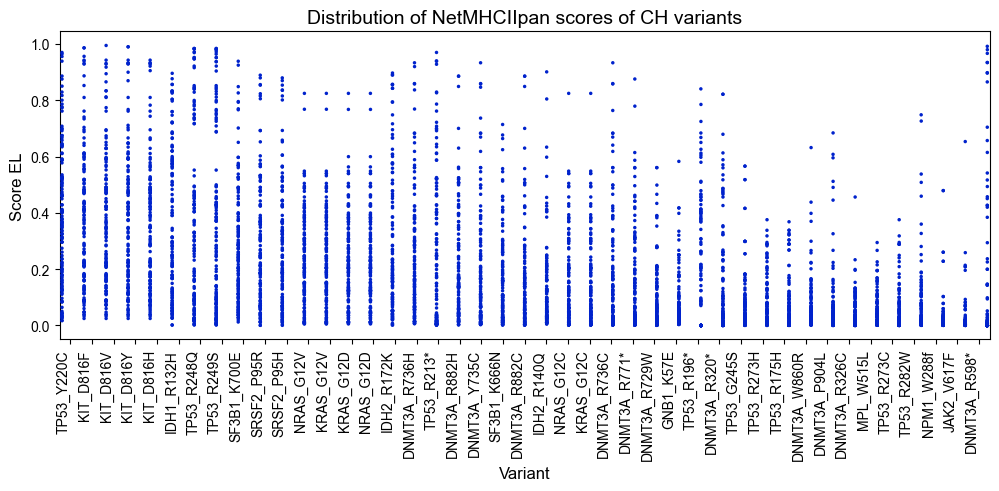

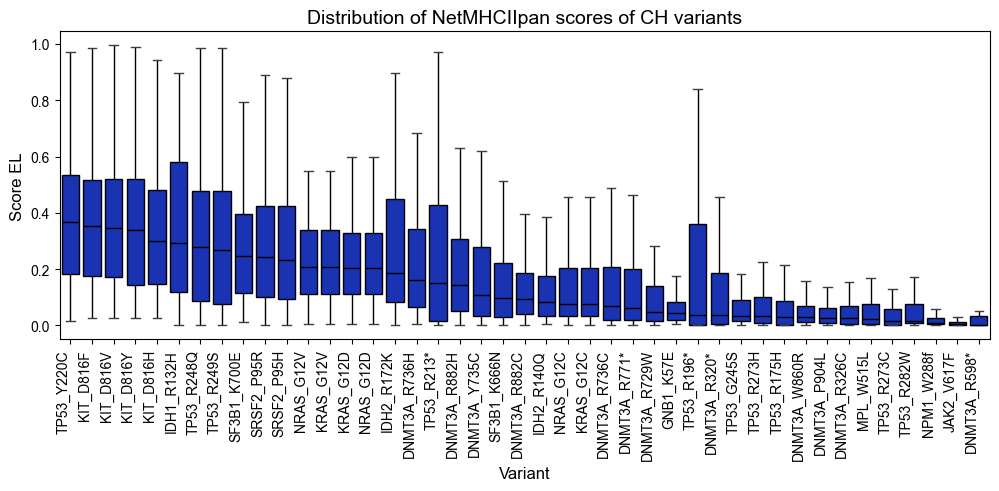

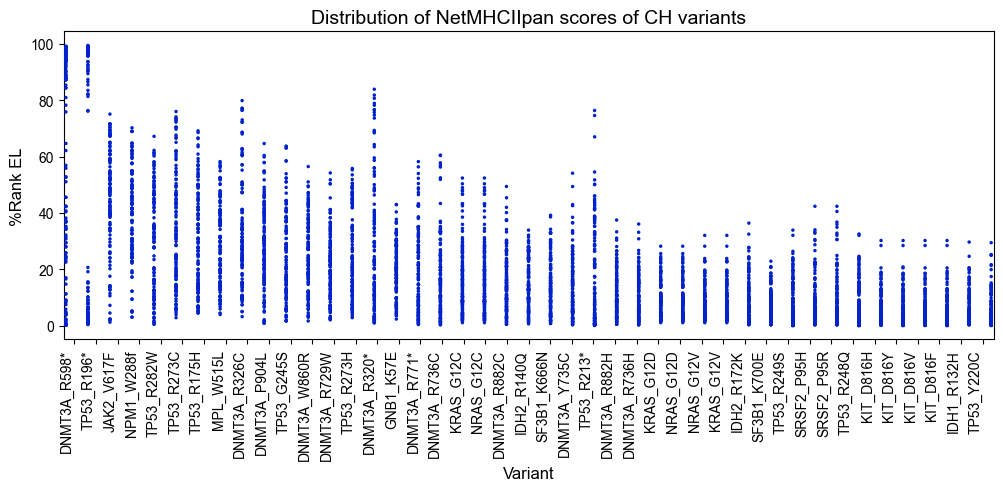

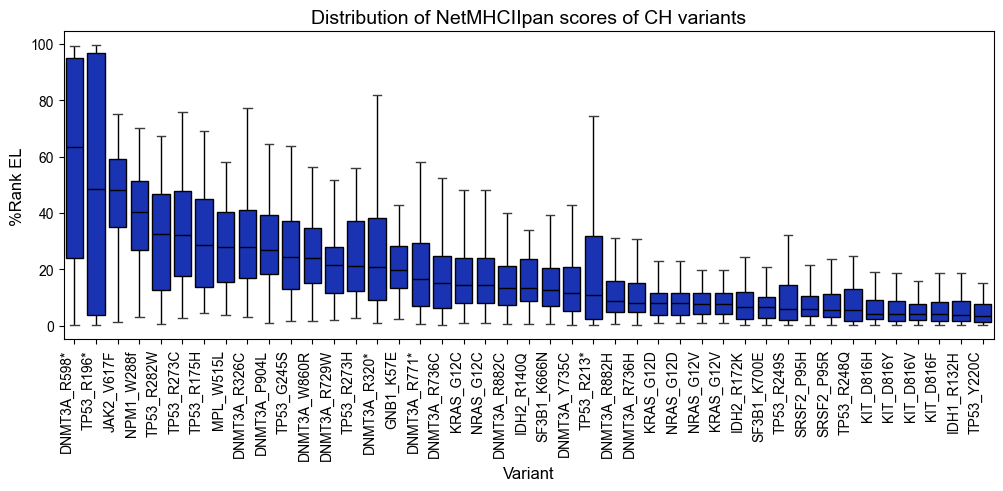

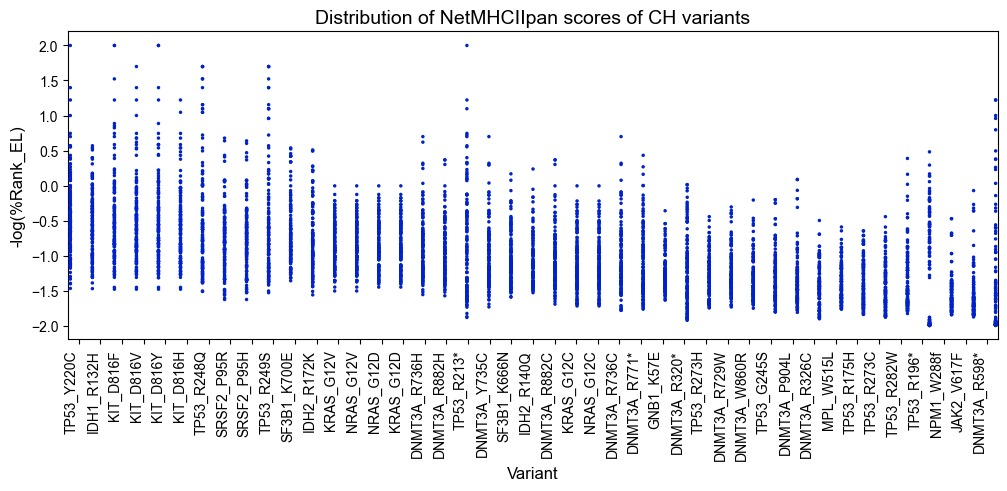

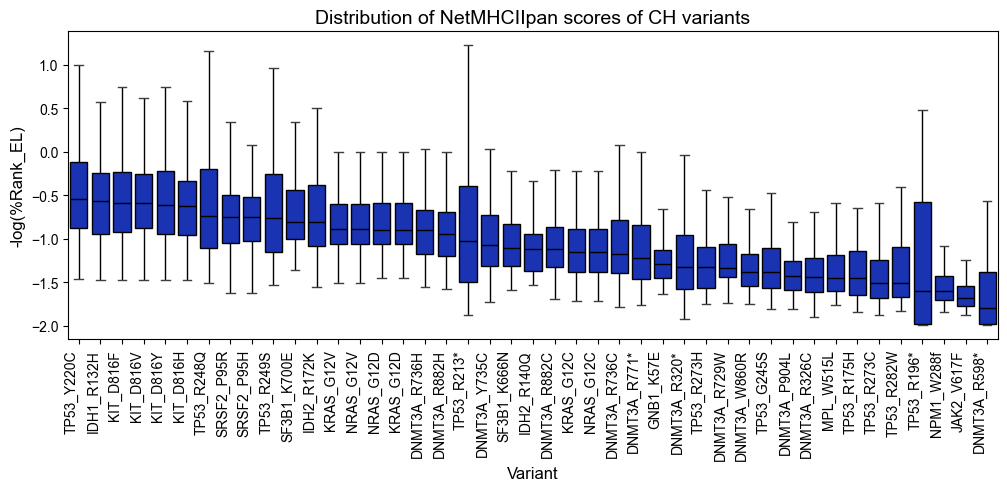

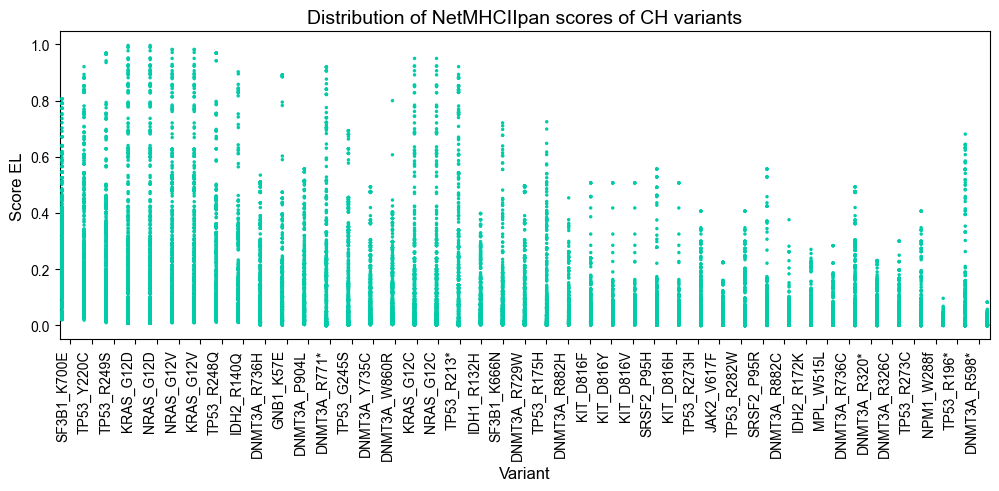

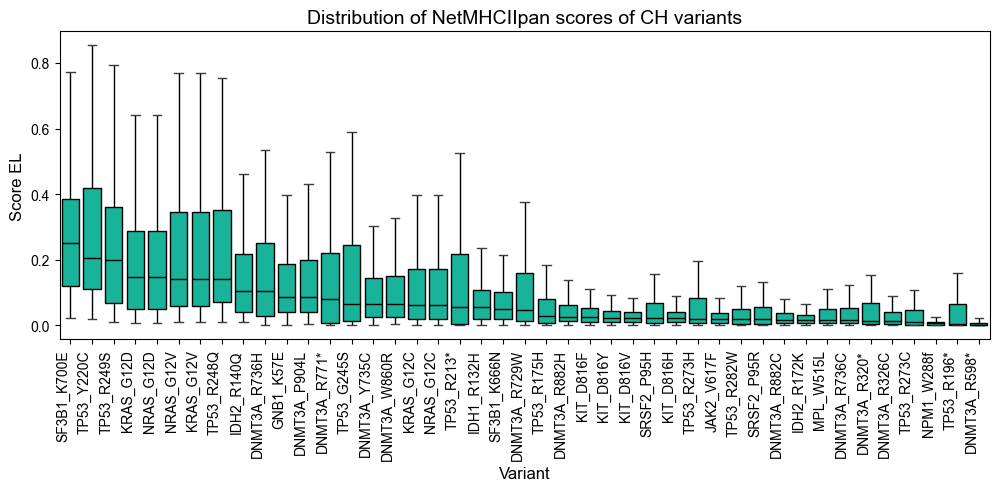

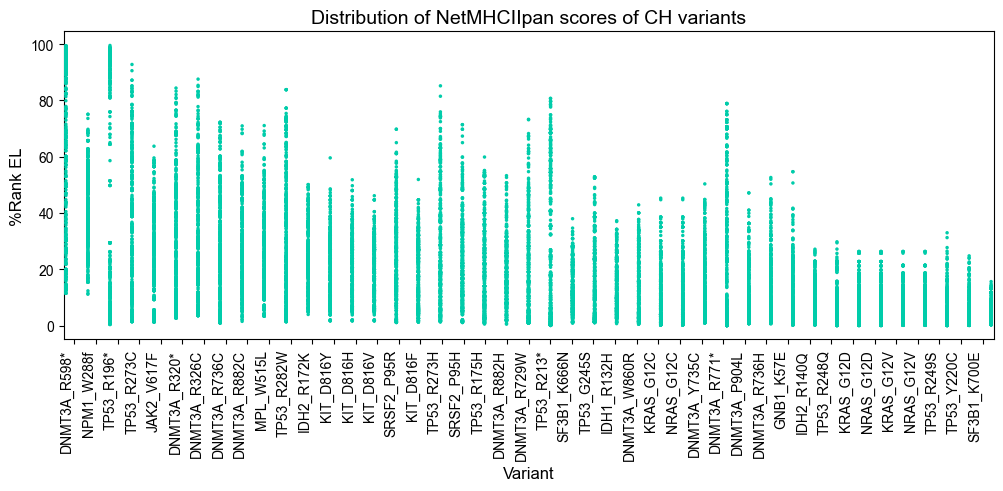

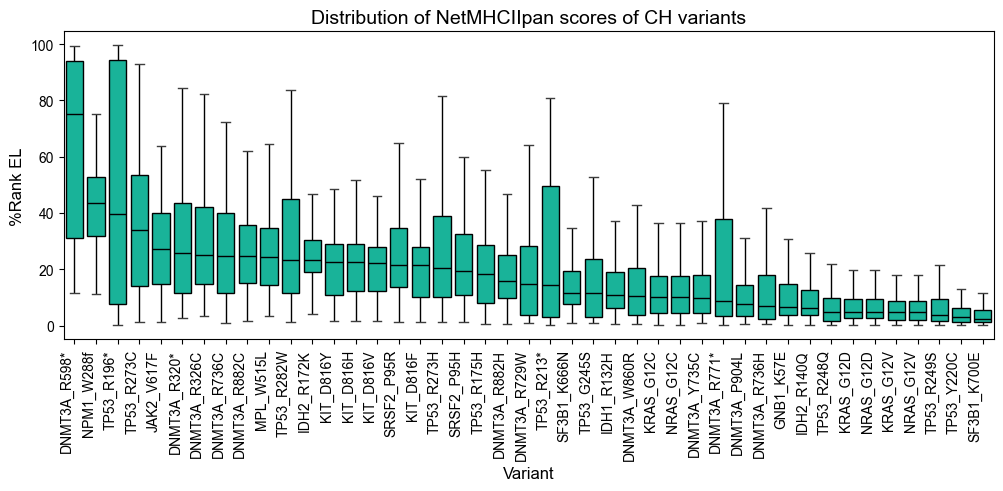

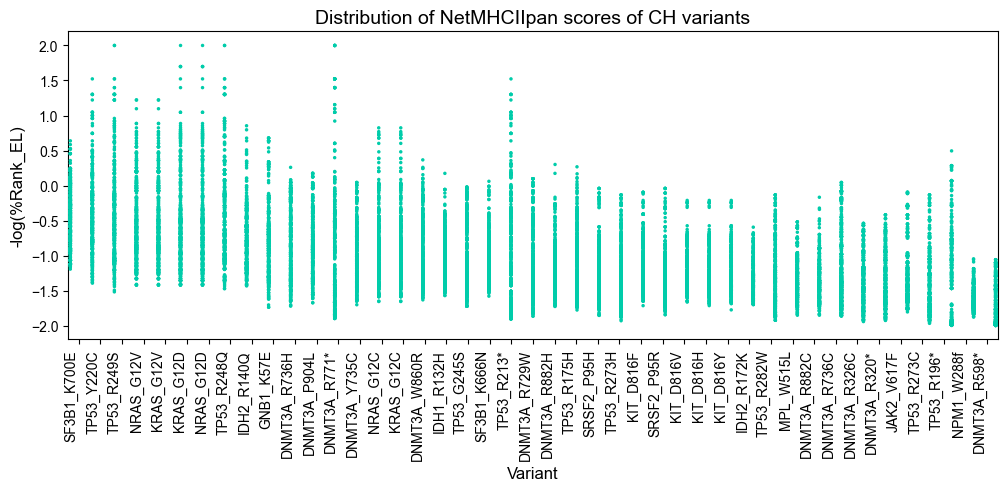

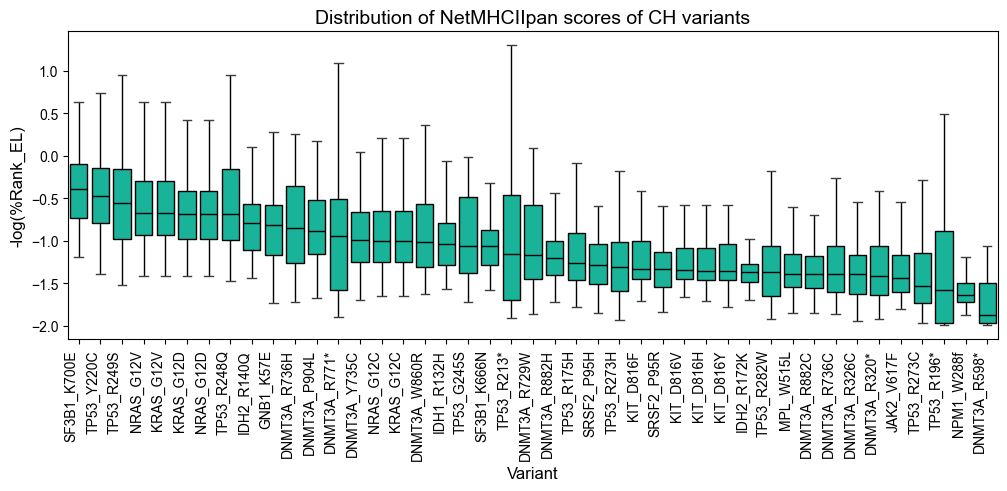

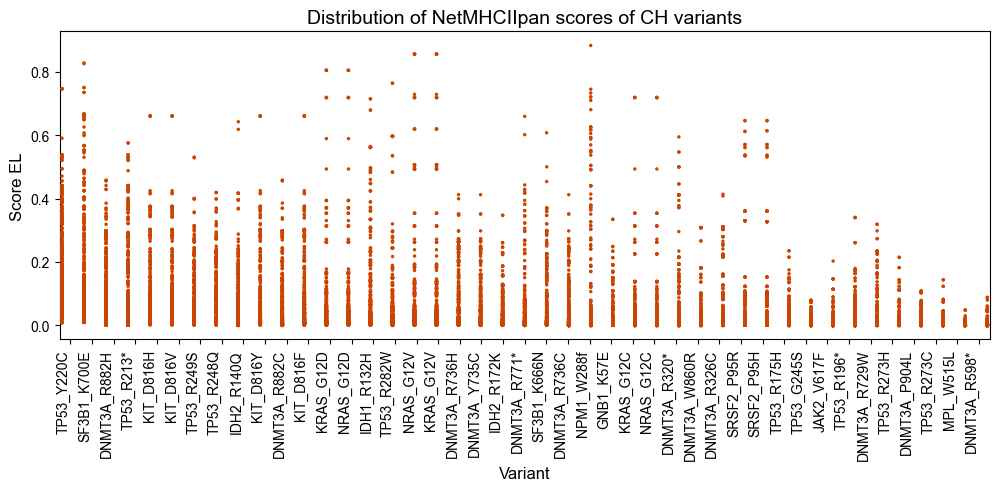

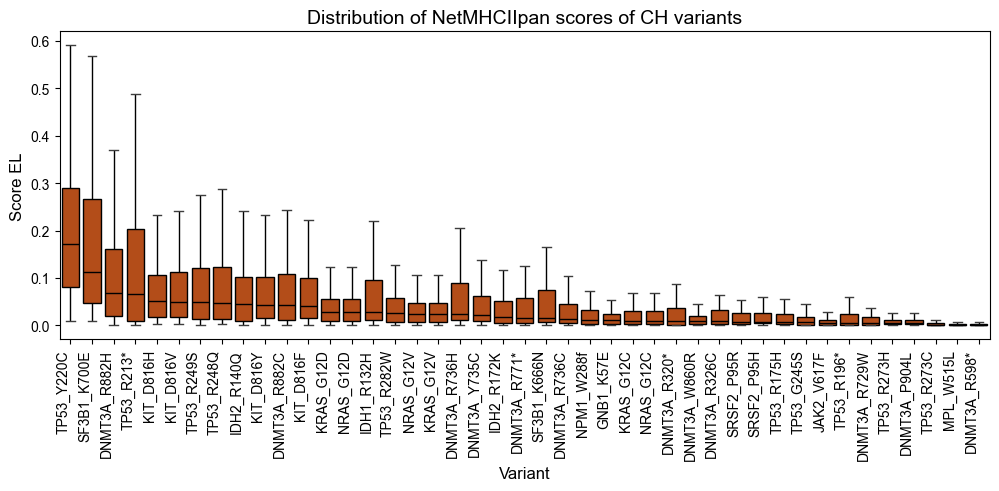

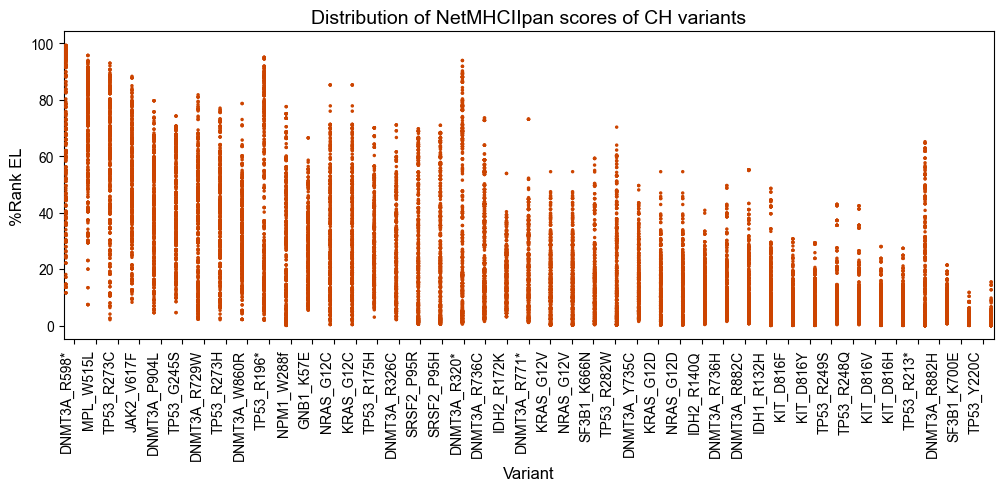

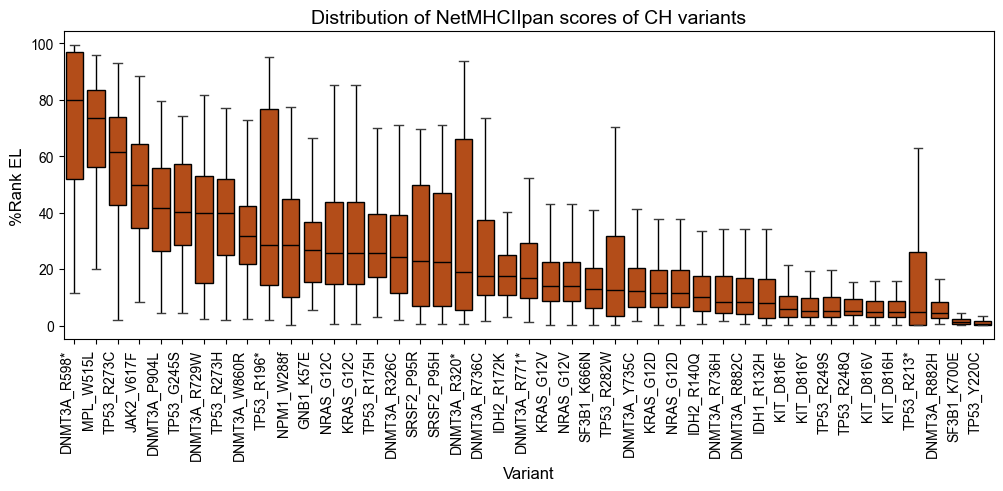

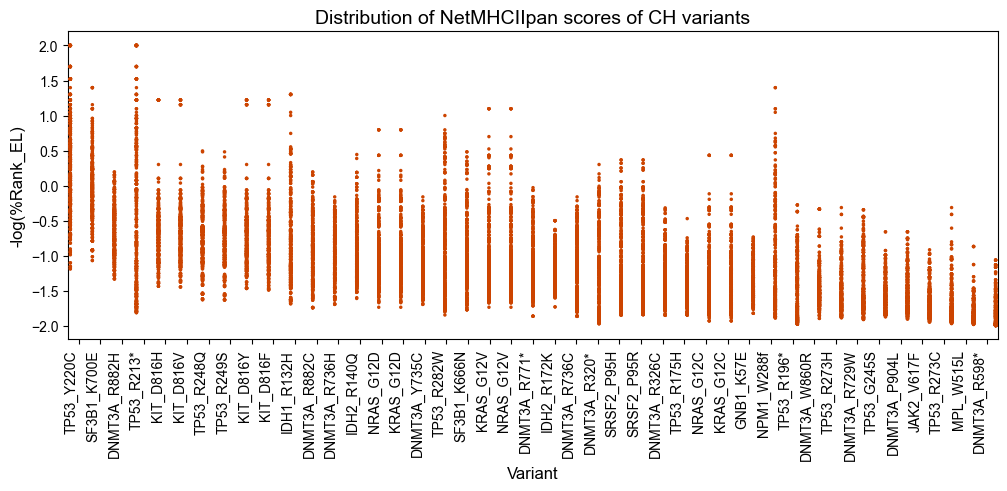

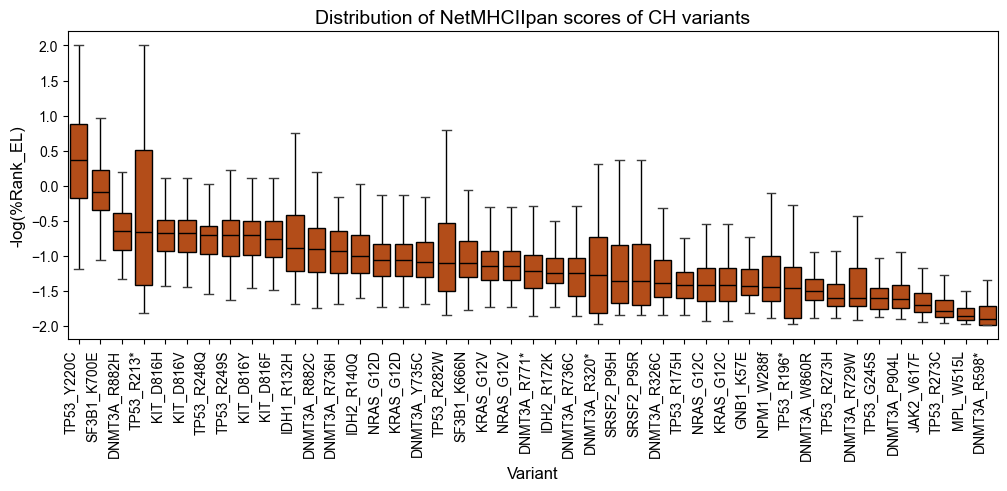

In [11]:
# now don't split and plot all or just single allele class

# not split

pred_df_dr = pred_df_all[pred_df_all['Allele_class']=='DR']
color = ['#0022cc']
plot_distribution_of_scores(pred_df_dr, 'gene_var', 'Score_EL', 'Score EL', color, 'jitter', 'dr')
plot_distribution_of_scores(pred_df_dr, 'gene_var', 'Score_EL', 'Score EL', color, 'box', 'dr')
plot_distribution_of_scores(pred_df_dr, 'gene_var', '%Rank_EL', '%Rank EL', color, 'jitter', 'dr')
plot_distribution_of_scores(pred_df_dr, 'gene_var', '%Rank_EL', '%Rank EL', color, 'box', 'dr')
plot_distribution_of_scores(pred_df_dr, 'gene_var', '%Rank_EL_log', '-log(%Rank_EL)', color, 'jitter', 'dr')
plot_distribution_of_scores(pred_df_dr, 'gene_var', '%Rank_EL_log', '-log(%Rank_EL)', color, 'box', 'dr')

pred_df_dp = pred_df_all[pred_df_all['Allele_class']=='DP']
color = ['#00ccaa']
plot_distribution_of_scores(pred_df_dp, 'gene_var', 'Score_EL', 'Score EL', color, 'jitter', 'dp')
plot_distribution_of_scores(pred_df_dp, 'gene_var', 'Score_EL', 'Score EL', color, 'box', 'dp')
plot_distribution_of_scores(pred_df_dp, 'gene_var', '%Rank_EL', '%Rank EL', color, 'jitter', 'dp')
plot_distribution_of_scores(pred_df_dp, 'gene_var', '%Rank_EL', '%Rank EL', color, 'box', 'dp')
plot_distribution_of_scores(pred_df_dp, 'gene_var', '%Rank_EL_log', '-log(%Rank_EL)', color, 'jitter', 'dp')
plot_distribution_of_scores(pred_df_dp, 'gene_var', '%Rank_EL_log', '-log(%Rank_EL)', color, 'box', 'dp')

pred_df_dq = pred_df_all[pred_df_all['Allele_class']=='DQ']
color = ['#cc4400']
plot_distribution_of_scores(pred_df_dq, 'gene_var', 'Score_EL', 'Score EL', color, 'jitter', 'dq')
plot_distribution_of_scores(pred_df_dq, 'gene_var', 'Score_EL', 'Score EL', color, 'box', 'dq')
plot_distribution_of_scores(pred_df_dq, 'gene_var', '%Rank_EL', '%Rank EL', color, 'jitter', 'dq')
plot_distribution_of_scores(pred_df_dq, 'gene_var', '%Rank_EL', '%Rank EL', color, 'box', 'dq')
plot_distribution_of_scores(pred_df_dq, 'gene_var', '%Rank_EL_log', '-log(%Rank_EL)', color, 'jitter', 'dq')
plot_distribution_of_scores(pred_df_dq, 'gene_var', '%Rank_EL_log', '-log(%Rank_EL)', color, 'box', 'dq')